# Simulate incidence calculations

This is a quick notebook to show why the incidence calculation for the ONS Community Infection Survey is tricky. ONS were not involved in writing it in any way, it's just some of my informal thoughts about the general technical problems involved as an independent academic. Feel free to reuse and adapt code with attribution.

Thomas House, University of Manchester, 9 Dec 2020


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

We assume we have a cohort of ten thousand, and pick their thresholds for becoming infectious under a given force of infection.

In [2]:
cohort_size = 10000
np.random.seed(14)
Q = np.sort(np.random.exponential(1.0,size=(cohort_size)))

Now consider ten weeks of following such a cohort, under exponentially growing force of infection with a doubling time of three weeks. Since we cannot always assume exponential growth, our aim is to learn the form of the 'force of infection' as quickly as possible.

In [3]:
tmax = 70.0
deltat = 7.0
r = np.log(2)/21
la0 = 1e-4
foi = lambda t : la0*np.exp(t*r)
foicum = lambda t : (la0/r)*(np.exp(t*r)-1.0) #Returns the cumulative force of infection at a given time
foiinv = lambda q : (1.0/r)*np.log(1+(q*r/la0)) #Inverse function

The next cells show what would happen if we had perfect observation of the times of new cases - basically, everything works out sensibly if we just look at the total cases per week, although there is a slight underestimate expected due to the exponential not being constant over the week.

In [4]:
Qinf = Q[Q<=foicum(tmax)]
tt = foiinv(Qinf)
C = np.arange(1,len(tt)+1)

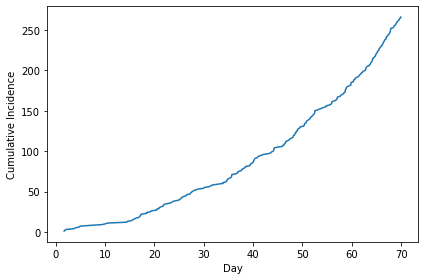

In [5]:
plt.plot(tt,C)
plt.xlabel('Day')
plt.ylabel('Cumulative Incidence')
plt.tight_layout()

In [6]:
zz, uu = np.histogram(tt,bins=np.arange(0,tmax+0.1,deltat))

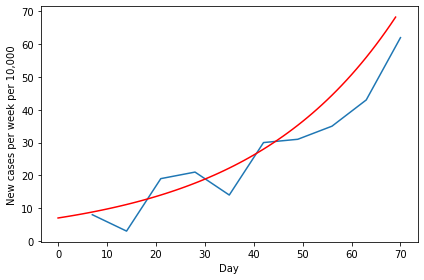

In [7]:
plt.plot(uu[1:],zz)
dd = np.arange(0,tmax)
plt.plot(dd,cohort_size*deltat*foi(dd),c='r')
plt.xlabel('Day')
plt.ylabel('New cases per week per 10,000')
plt.tight_layout()

Now suppose that we simulate something like the sampling frame of the ONS survey, where individuals are followed up weekly (in fact, things are more complex in reality because the first few follow ups are weekly, then they move to monthly). Then just looking at the totals over the last week will consistently underestimate quite a lot, because most positive results became positive before they were visited.

In [8]:
tsamp = np.zeros(len(tt))

In [9]:
for i, t in enumerate(tt):
    tsamp[i] = t + np.random.uniform(low=0.0, high=7.0)

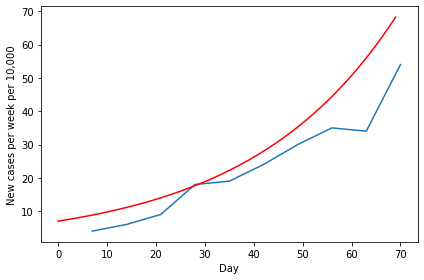

In [10]:
zz, uu = np.histogram(tsamp,bins=np.arange(0,tmax+0.1,deltat))
plt.plot(uu[1:],zz)
dd = np.arange(0,tmax)
plt.plot(dd,cohort_size*deltat*foi(dd),c='r')
plt.xlabel('Day')
plt.ylabel('New cases per week per 10,000')
plt.tight_layout()

One possible first step for dealing with this is to perform a midpoint imputation - i.e. move the observations back half a week. The problem with doing this in real time is that the newest data isn't in yet, so the latest estimate that everyone is most interested in is **far** too low.

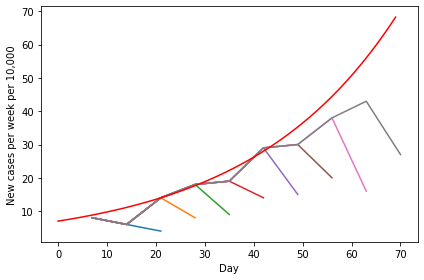

In [11]:
for tcut in np.arange(21,tmax+0.1,7):
    zz, uu = np.histogram(tsamp[tsamp<tcut]-3.5,bins=np.arange(0,tcut+0.1,deltat))
    plt.plot(uu[1:],zz)
dd = np.arange(0,tmax)
plt.plot(dd,cohort_size*deltat*foi(dd),c='r')
plt.xlabel('Day')
plt.ylabel('New cases per week per 10,000')
plt.tight_layout()

So then the next correction is to adjust for time at risk - in this case, note that the final observed points have been at risk for on average half the time - incidence is defined as new cases / time at risk, after all. This leads to a better estimate, but at the cost that we will have to revise that estimate next week.

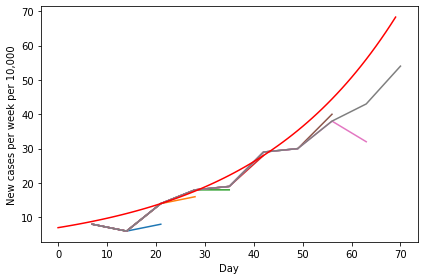

In [12]:
for tcut in np.arange(21,tmax+0.1,7):
    zz, uu = np.histogram(tsamp[tsamp<tcut]-3.5,bins=np.arange(0,tcut+0.1,deltat))
    zz[-1] *= 2
    plt.plot(uu[1:],zz)
dd = np.arange(0,tmax)
plt.plot(dd,cohort_size*deltat*foi(dd),c='r')
plt.xlabel('Day')
plt.ylabel('New cases per week per 10,000')
plt.tight_layout()

In summary, revision of past estimates of incidence is the price one pays for maximally timely information from a study of incidence based on repeat visits. The size of the revision can be much bigger if there is more noise in the system, as there always will be for real data. It doesn't mean that any model involved was wrong, and simply reflects the finite nature of the sample and hence variable nature of any estimators involved.